In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!unzip -q '/content/drive/MyDrive/mp_dataset/new-plant-diseases-dataset.zip' -d '/content'
# drive.flush_and_unmount() 


Mounted at /content/drive
replace /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_270deg.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = '/content/test_files'

In [24]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
import numpy as np
import os, shutil

In [26]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [27]:
newpath = '/content/test_files' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

x = os.listdir(train_dir)
for dir_names in x:
  # print(dir_names)
  p = os.listdir(os.path.join(train_dir, dir_names))
  if not os.path.exists(os.path.join(newpath, dir_names)):
    os.makedirs(os.path.join(newpath, dir_names))
  cnt = 0
  file_names = []
  for image_names in p:
    if cnt==250:
      break
    file_names.append(train_dir+'/'+dir_names+'/'+image_names)
    cnt += 1
  for f in file_names:
    shutil.move(f, os.path.join(newpath, dir_names))
    



In [31]:
train_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

Found 60795 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 9500 images belonging to 38 classes.


In [32]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)

In [33]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 64)                8256

In [34]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [35]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
model_main.fit(train,validation_data=valid,epochs=30,steps_per_epoch=200,verbose=1,callbacks=[es, lr])

Epoch 1/30
200/200 [==============================] - 177s 756ms/step - loss: 1.5447 - accuracy: 0.5817 - val_loss: 0.7002 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 146s 733ms/step - loss: 0.5356 - accuracy: 0.8402 - val_loss: 0.4747 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 147s 736ms/step - loss: 0.4066 - accuracy: 0.8711 - val_loss: 0.3359 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 147s 736ms/step - loss: 0.3304 - accuracy: 0.8959 - val_loss: 0.2793 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 146s 732ms/step - loss: 0.2815 - accuracy: 0.9097 - val_loss: 0.2661 - val_accuracy: 0.9132 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 147s 734ms/step - loss: 0.2491 - accuracy: 0.9203 - val_loss: 0.2363 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 7/30
200/200 [==========================

In [38]:
model_main.save("efficientnetv2s_PLANT_DISEASE.h5")

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

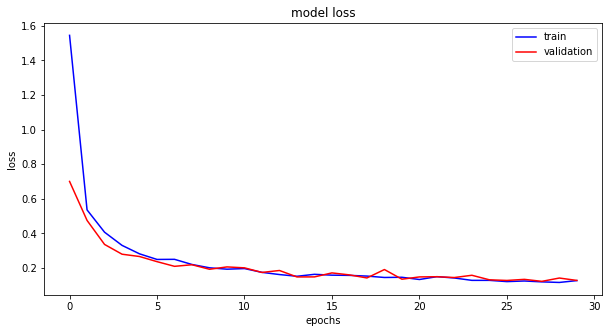

In [41]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

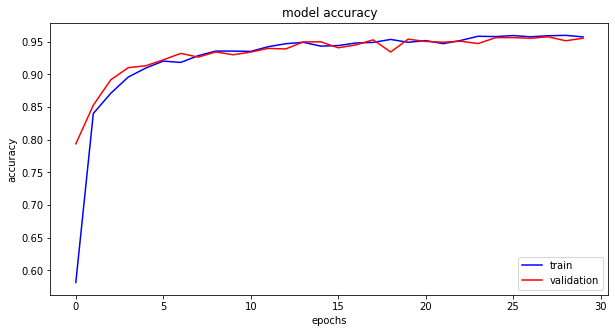

In [42]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [44]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1900/1900 [==============================] - 731s 384ms/step - loss: 0.1130 - accuracy: 0.9606
Train: accuracy = 0.960589  ;  loss = 0.112972
550/550 [==============================] - 73s 132ms/step - loss: 0.1278 - accuracy: 0.9553
Validation: accuracy = 0.955327  ;  loss = 0.127811
297/297 [==============================] - 40s 135ms/step - loss: 0.1254 - accuracy: 0.9584
Test: accuracy = 0.958421  ;  loss = 0.125422


In [45]:
model = load_model("/content/efficientnetv2s_PLANT_DISEASE.h5")

In [47]:
img = tensorflow.keras.utils.load_img(
    "/content/test/test/Potato___Early_blight/PotatoEarlyBlight1.JPG",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)

In [48]:
probability_model = tensorflow.keras.Sequential([model, 
                                         tensorflow.keras.layers.Softmax()])

In [49]:
predict = probability_model.predict(input_arr)

In [50]:
predict[0]

array([0.0251776 , 0.02517755, 0.02517755, 0.02517755, 0.02517755,
       0.02517755, 0.02517755, 0.02517755, 0.02517755, 0.02517755,
       0.02517755, 0.02517755, 0.02517755, 0.02517755, 0.02517755,
       0.02517755, 0.02517755, 0.02517755, 0.02517755, 0.02517755,
       0.06842563, 0.0251825 , 0.02517755, 0.02517755, 0.02517755,
       0.02517755, 0.02517755, 0.02517755, 0.02517755, 0.02517763,
       0.02517761, 0.02517755, 0.02517755, 0.02517755, 0.02517755,
       0.02517755, 0.02517755, 0.02517755], dtype=float32)

In [51]:
classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [52]:
p = np.argmax(predict[0])
print(classes[p])

Potato___Early_blight
